In [1]:
#Import libraries
from data_loader import FootballDataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Masking, GRU, Dense, Dropout, TimeDistributed, RepeatVector
)
import matplotlib.pyplot as plt


Reading game 1: Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Loading Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Data read.
Time shape: (155541, 2)
Ball shape: (155541, 6)
Team shape: (155541, 60)
Opponent shape: (155541, 64)
Total shape: (88002, 132)
Opponent name detected from filename: RFC

=== DataFrame Overview ===
Shape: (88002, 132)

Columns:
['Time', 'half', 'Ball_x', 'Ball_y', 'game', 'Ball_z', 'Ball_Speed?', 'Ball_Col5', 'FCKplayer_1_x', 'FCKplayer_1_y', 'FCKplayer_1_speed_x', 'FCKplayer_1_number', 'FCKplayer_2_x', 'FCKplayer_2_y', 'FCKplayer_2_speed_x', 'FCKplayer_2_number', 'FCKplayer_4_x', 'FCKplayer_4_y', 'FCKplayer_4_speed_x', 'FCKplayer_4_number', 'FCKplayer_8_x', 'FCKplayer_8_y', 'FCKplayer_8_speed_x', 'FCKplayer_8_number', 'FCKplayer_10_x', 'FCKplayer_10_y', 'FCKplayer_10_speed_x', 'FCKplayer_10_number', 'FCKplayer_11_x', 'FCKplayer_11_y', 'FCKplayer_11_speed_x', 'FCKplayer_11_number', 'FCKplayer_13_x', 'FCKplayer_13_y', 'FCKplayer_13_speed_x', 'FCKplayer_13_number', 'FC

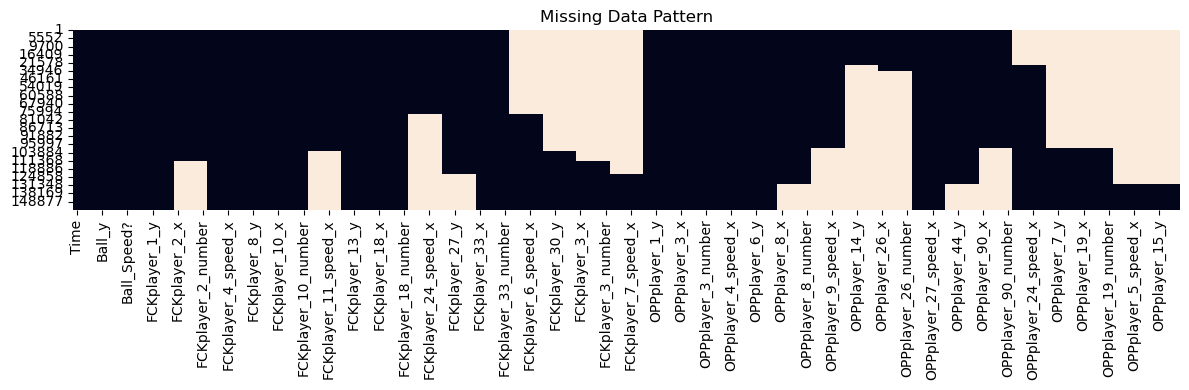

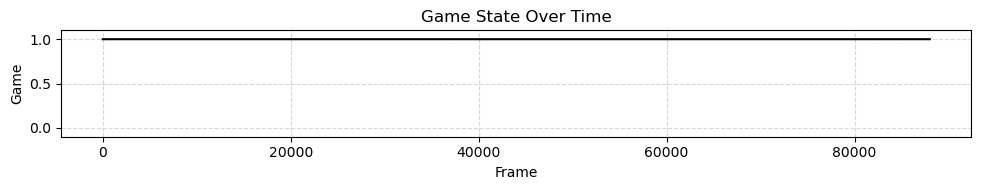

Reading game 2: Game_FCK_VFF_Score_1_1_Day_2024-08-18Z.pkl
Loading Game_FCK_VFF_Score_1_1_Day_2024-08-18Z.pkl
Data read.
Time shape: (158121, 2)
Ball shape: (158121, 6)
Team shape: (158121, 64)
Opponent shape: (158121, 64)
Total shape: (90691, 136)
Opponent name detected from filename: VFF

=== DataFrame Overview ===
Shape: (90691, 136)

Columns:
['Time', 'half', 'Ball_x', 'Ball_y', 'game', 'Ball_z', 'Ball_Speed?', 'Ball_Col5', 'FCKplayer_1_x', 'FCKplayer_1_y', 'FCKplayer_1_speed_x', 'FCKplayer_1_number', 'FCKplayer_2_x', 'FCKplayer_2_y', 'FCKplayer_2_speed_x', 'FCKplayer_2_number', 'FCKplayer_3_x', 'FCKplayer_3_y', 'FCKplayer_3_speed_x', 'FCKplayer_3_number', 'FCKplayer_5_x', 'FCKplayer_5_y', 'FCKplayer_5_speed_x', 'FCKplayer_5_number', 'FCKplayer_8_x', 'FCKplayer_8_y', 'FCKplayer_8_speed_x', 'FCKplayer_8_number', 'FCKplayer_12_x', 'FCKplayer_12_y', 'FCKplayer_12_speed_x', 'FCKplayer_12_number', 'FCKplayer_24_x', 'FCKplayer_24_y', 'FCKplayer_24_speed_x', 'FCKplayer_24_number', 'FCKpla

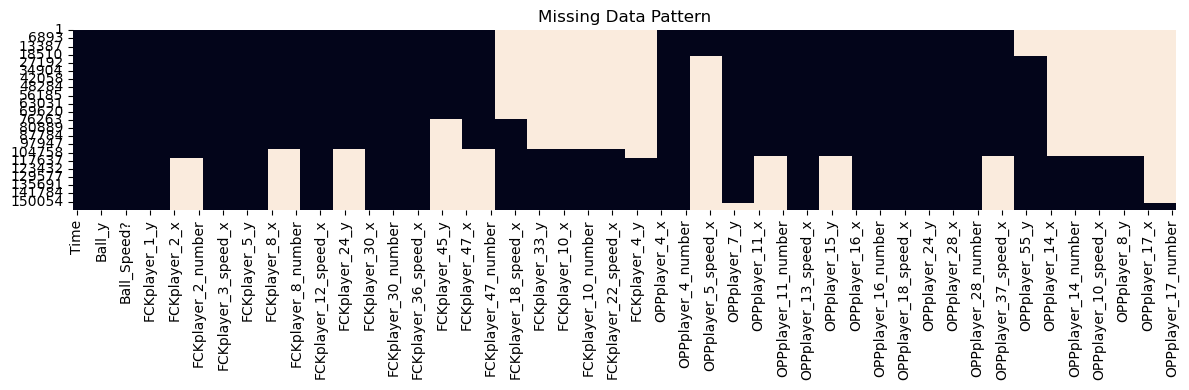

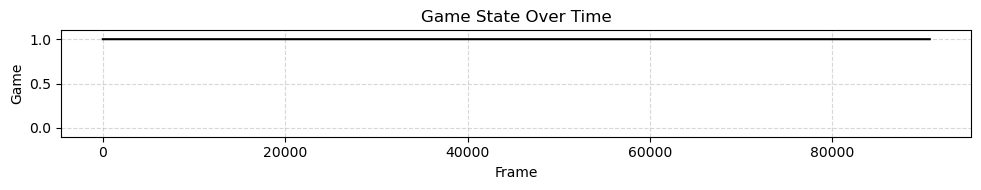

In [2]:
#Getting the data
data_dir = r"\Users\kirlo\Documents\Sanvi University Work\Year 3\AML\final project\FootballData\RestructuredData_2425"  # replace with your actual data directory
team = "FCK"         
data_retriever = FootballDataLoader(data_dir, team)
all_games = data_retriever.load_all_games(n_games=2, speed_player= True, speed_ball=True, player_z=False, ball_z = True, )  

In [3]:
all_columns = set()
for game in all_games:
    all_columns.update(game.columns)

all_columns = sorted(list(all_columns))  # sort for consistency

uniform_games = []
for game in all_games:
    padded_columns = game.reindex(columns=all_columns, fill_value=-999.0)
    padded_columns = padded_columns.astype(np.float32)
    uniform_games.append(padded_columns)



In [ ]:
#Dropping unnecessary columns
reduced_games = []

for game in uniform_games:
    position_columns = [
        col for col in game.columns 
        if (
            ('player' in col and (col.endswith('_x') or col.endswith('_y') or 'speed' in col)) or
            ('ball' in col.lower() and (col.endswith('_x') or col.endswith('_y') or col.endswith('_z') or 'speed' in col.lower()))
        )
    ]

    game_reduced = game[position_columns]
    reduced_games.append(game_reduced)

In [5]:
#Standardising data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_data = pd.concat(reduced_games, ignore_index=True)
scaler.fit(all_data)
normalized_games = []
for game in reduced_games:
    normalized_game = pd.DataFrame(scaler.transform(game), columns=game.columns)
    normalized_games.append(normalized_game)


In [6]:
#Creating the autoencoder sequence
window_size = 75 #how far back in time the neural network will look to predict the future
horizon = 75 # how far into the future the neural network will predict
test_index = 0
#I kept window size and horizon small for my laptop sake but you can change them to what you need for the xgs

train_past = []
train_future = []


#Essentially the neural network will take window_size number of time steps in the past and predict beginning from horizon time steps after the last training time step
def sequences(data, time_steps, horizon):
    inputs = []
    targets = []
    for i in range(len(data) - time_steps - horizon + 1):
        input_seq = data[i : i + time_steps]
        target_seq = data[i + horizon : i + time_steps + horizon]
        inputs.append(input_seq)
        targets.append(target_seq)
    return np.array(inputs), np.array(targets)

#times = normalized_game.iloc[1000:] #Here you can control where you want to start sequence generation. 1000: means it starts from the 1000th timestep
#past, future = sequences(times.values, window_size, horizon)

for idx, game in enumerate(reduced_games):
    if idx == test_index:
        continue
    normalized = scaler.transform(game.values)
    X, y = sequences(normalized, window_size, horizon)
    #train_past.append(X)
    # Use only data from the 1000th timestep onward for both input and target
    normalized_game = pd.DataFrame(normalized, columns=game.columns)
    times = normalized_game.iloc[1000:]
    X, y = sequences(times.values, window_size, horizon)
    train_past.append(X)
    train_future.append(y)

X_train = np.concatenate(train_past, axis=0)
y_train = np.concatenate(train_future, axis=0)

test_game = reduced_games[test_index]
normalized_test = scaler.transform(test_game.values)
X_test, y_test = sequences(normalized_test, window_size, horizon)


c:\Users\kirlo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kirlo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [7]:
#padding the sequences
pad_value = -999.9 #Set this to 0 if you want the predictions to be better. Doesnt make much sense to me though
past = np.nan_to_num(X_train, nan=pad_value)
future = np.nan_to_num(y_train, nan=pad_value)
x_test = np.nan_to_num(X_test, nan=pad_value)
y_test = np.nan_to_num(y_test, nan=pad_value)

pad_value = np.float32(pad_value)
past = past.astype(np.float32)
future = future.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)


In [8]:
#Building neural network
model = Sequential([
    Masking(mask_value=pad_value, input_shape=(past.shape[1], past.shape[2])),
    GRU(64, return_sequences=False),
    RepeatVector(past.shape[1]),  
    GRU(64, return_sequences=True),
    TimeDistributed(Dense(past.shape[2]))  #
])
model.compile(optimizer='adam', loss='mse')



c:\Users\kirlo\anaconda3\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Find NaNs in past and future arrays
nans_in_past = np.isnan(past).sum()
nans_in_future = np.isnan(future).sum()

print(f"Number of NaNs in 'past': {nans_in_past}")
print(f"Number of NaNs in 'future': {nans_in_future}")

Number of NaNs in 'past': 0
Number of NaNs in 'future': 0


In [10]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(past, future, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 228s 97ms/step - loss: 196823.3281 - val_loss: 171209.0469
Epoch 2/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 175s 78ms/step - loss: 148248.8125 - val_loss: 138211.9688
Epoch 3/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 173s 77ms/step - loss: 109719.8203 - val_loss: 110342.6172
Epoch 4/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 174s 78ms/step - loss: 79299.2500 - val_loss: 87535.2578
Epoch 5/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 181s 81ms/step - loss: 56001.0625 - val_loss: 69656.1406
Epoch 6/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 166s 74ms/step - loss: 39370.2617 - val_loss: 55117.8828
Epoch 7/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 178s 80ms/step - loss: 28846.5352 - val_loss: 43046.9492
Epoch 8/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 176s 79ms/step - loss: 22883.1895 - val_loss: 32859.9805
Epoch 9/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 189s 84ms/step - loss: 19399.4785 - val_loss: 24037.9727
Epoch 10/50
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 182s 81ms/step - loss: 17108.5645 - val_loss: 17751.5059
Epo

KeyboardInterrupt: 

In [ ]:
y_test_predictions = model.predict(x_test, batch_size=16)
#x_test_predictions = model.predict(x_test, batch_size=16)

MemoryError: Unable to allocate 3.48 GiB for an array with shape (87803, 75, 142) and data type float32

In [ ]:
#Unnormalizing the predictions
y_predictions = scaler.inverse_transform(y_test_predictions.reshape(-1, y_test_predictions.shape[-1])).reshape(y_test_predictions.shape)
#x_predictions = scaler.inverse_transform(x_test_predictions.reshape(-1, x_test_predictions.shape[-1])).reshape(x_test_predictions.shape)

In [ ]:

# Get just the first prediction
single_pred = y_predictions[0]  # shape: (horizon, n_features)

# Use correct column names
column_names = reduced_games[test_index].columns

# Timestamps for that one prediction
start_idx = 1000  # or whatever timestep you want
output_indices = list(range(start_idx + window_size, start_idx + window_size + horizon))

# Create DataFrame
df_predictions = pd.DataFrame(single_pred, columns=column_names)
df_predictions["timestamp"] = output_indices
df_predictions = df_predictions.set_index("timestamp").reset_index()



In [ ]:
df_predictions

,timestamp,Ball_Speed?,Ball_x,Ball_y,Ball_z,FCKplayer_10_speed_x,FCKplayer_10_x,FCKplayer_10_y,FCKplayer_11_speed_x,FCKplayer_11_x,...,OPPplayer_7_y,OPPplayer_8_speed_x,OPPplayer_8_x,OPPplayer_8_y,OPPplayer_90_speed_x,OPPplayer_90_x,OPPplayer_90_y,OPPplayer_9_speed_x,OPPplayer_9_x,OPPplayer_9_y
0,1010,9.585342,5.441503,4.961259,0.277104,-16.559177,-245.505890,-192.124207,-753.047546,-745.309448,...,-2.625452,-17.182974,-255.239258,-167.203873,-622.777283,-576.205383,-732.317688,-727.291626,-583.959106,-756.652832
1,1011,9.844232,5.392203,5.870012,0.047785,-57.523190,-795.579651,-609.604614,-858.294861,-859.724243,...,-9.434548,-58.217648,-814.176270,-526.154236,-699.252502,-649.066345,-786.703064,-822.895386,-699.520447,-844.676880
2,1012,8.342206,3.364753,3.834827,0.432639,-120.781181,-1642.332031,-1247.109131,-949.777893,-969.085571,...,-11.588687,-120.932793,-1673.088013,-1072.180176,-869.497681,-847.495239,-904.796814,-957.924133,-897.386353,-933.885193
3,1013,7.407098,2.205449,0.568199,0.865892,-151.911392,-2057.324951,-1558.914185,-992.327637,-1015.456177,...,-11.837657,-151.666931,-2093.590088,-1338.849121,-996.820312,-974.969238,-990.734619,-1002.360657,-998.537170,-998.924500
4,1014,7.352021,2.120466,0.054980,0.913976,-154.771042,-2095.317871,-1587.613281,-998.552063,-1017.288452,...,-11.939708,-154.489594,-2132.193604,-1363.292480,-1009.937378,-991.072632,-999.603760,-1004.432068,-1007.215820,-1008.243591
5,1015,7.350251,2.115655,0.019323,0.916818,-154.911789,-2097.189209,-1589.032471,-999.093445,-1017.272339,...,-11.951474,-154.629257,-2134.099609,-1364.498779,-1010.522034,-992.009766,-1000.073120,-1004.499084,-1007.628479,-1008.826111
6,1016,7.350188,2.115278,0.017102,0.916988,-154.918976,-2097.284668,-1589.105469,-999.132874,-1017.271301,...,-11.952378,-154.636459,-2134.196777,-1364.560181,-1010.546692,-992.060242,-1000.099121,-1004.502625,-1007.650024,-1008.861572
7,1017,7.350187,2.115246,0.016962,0.916998,-154.919373,-2097.290283,-1589.109497,-999.135498,-1017.271484,...,-11.952439,-154.636841,-2134.202393,-1364.563965,-1010.547791,-992.063049,-1000.100708,-1004.502808,-1007.651367,-1008.863892
8,1018,7.350187,2.115244,0.016959,0.916999,-154.919388,-2097.290283,-1589.109497,-999.135742,-1017.271484,...,-11.952439,-154.636887,-2134.202637,-1364.563965,-1010.547791,-992.063171,-1000.100830,-1004.502808,-1007.651428,-1008.864014
9,1019,7.350187,2.115242,0.016957,0.916999,-154.919388,-2097.290283,-1589.109619,-999.135681,-1017.271423,...,-11.952441,-154.636902,-2134.202637,-1364.563965,-1010.547852,-992.063232,-1000.100830,-1004.502747,-1007.651428,-1008.863953


RUnning


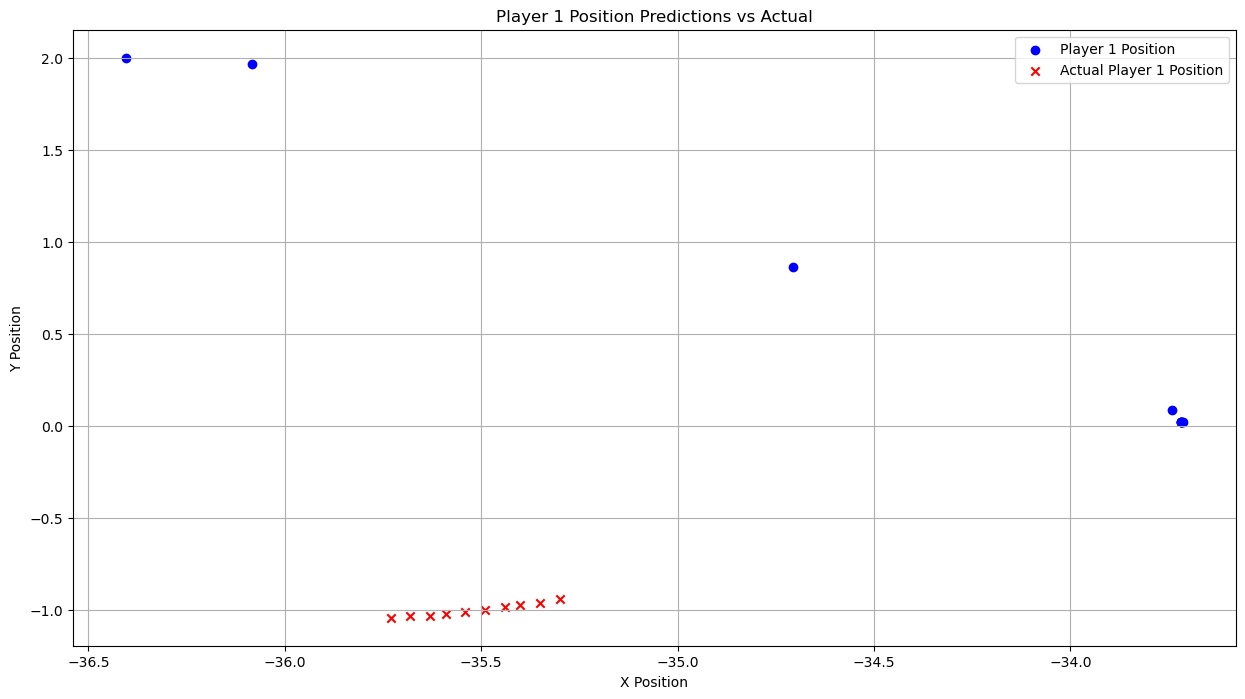

In [ ]:
#Plotting the predictions
%matplotlib inline
player_1_x = df_predictions['FCKplayer_1_x']
player_1_y = df_predictions['FCKplayer_1_y']
actualp1_x = test_game['FCKplayer_1_x'].iloc[1000 + window_size:1000 + window_size + horizon]
actualp1_y = test_game['FCKplayer_1_y'].iloc[1000 + window_size:1000 + window_size + horizon]
plt.figure(figsize=(15, 8))
plt.scatter(player_1_x, player_1_y, label='Player 1 Position', color='blue')
plt.scatter(actualp1_x, actualp1_y, label='Actual Player 1 Position', color='red', marker='x')
plt.title('Player 1 Position Predictions vs Actual')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
print("RUnning")
plt.show()